In [130]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
from keras import backend as K
from keras.callbacks import TensorBoard
import numpy as np
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import signal
import scipy.fftpack
import os

Using TensorFlow backend.


In [131]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/Sub4_EEG.xlsx


In [132]:
# data is loaded

df = pd.read_excel('/kaggle/input/Sub4_EEG.xlsx', index_col=None, header=None)

col = []
for i in range(32):
  col.append("x"+str(i))
col.append('y')
df.columns = col

y = np.array(df[['y']]).T[0]
yes = []  # All index with lable 1
no = []  # All index with lable 0
j = 0
for i in y:
  if i == 0:
    yes.append(j)
  else:
    no.append(j)
  j += 1


In [ ]:
## Sampling The DataSET
# yes_sampled = []
# no_sampled = []
# for i in range(min(len(yes),len(no))):
#     if i%5 == 0:
#                yes_sampled.append(yes[i])
#                no_sampled.append(no[i])
        
# yes_sampled = yes_sampled[0:int(len(yes_sampled)/20)]
# no_sampled = no_sampled[0:int(len(no_sampled)/20)]
# yes_sampled = yes[0:int(len(yes_sampled)/20)]
# no_sampled = no[0:int(len(no_sampled)/20)]


In [ ]:
# To save all the plots of 32 signals with different colour denoting mentally stressed or not at that moment

for it in range(32):  
    
    xn = "x"+str(it)


    x=no_sampled,
    y=list(df.iloc[x][xn].T),
    plt.plot(x,y,'ro',markersize=1,label="no",alpha=0.5);

    x=yes_sampled,
    y=list(df.iloc[x][xn].T),
    plt.plot(x,y,'bo',markersize=1,label="yes",alpha=0.5);

    plt.title(it)
    plt.savefig("plot_sam_"+str(it)+".png")
    plt.close()

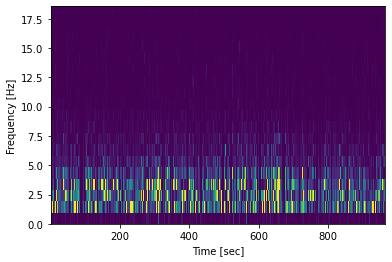

In [133]:
# Plotting Spectrogram Analysis

it = "0" # between 0 to 31
xn = "x"+str(it)   
x = np.array(df.iloc[:][xn].T)  
f, t, Sxx = signal.spectrogram(x,fs = 250)
Sxx = Sxx[0:20,:]
t = t
f = f[0:20]
plt.pcolormesh(t, f, Sxx,vmin = 0,vmax = 1000)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

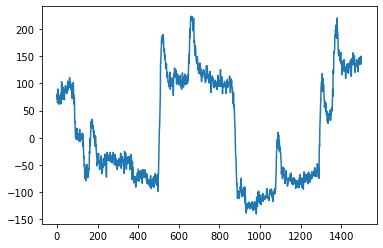

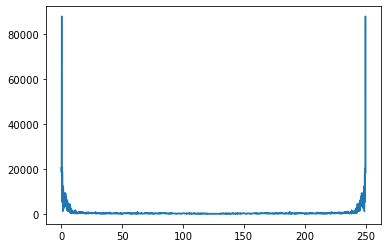

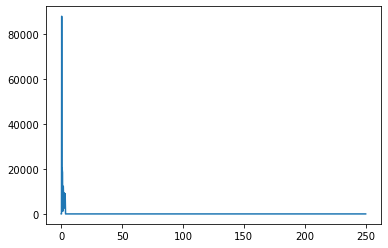

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


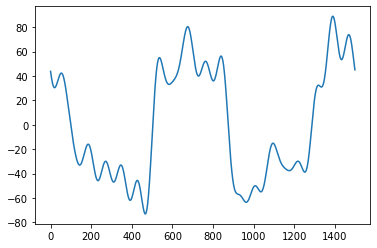

In [134]:
# Plottting FFT Analysis

it = "0"# between 0 to 31
xn = "x"+str(it)  
x = np.array(df.iloc[1:1500][xn].T)
t = np.arange(len(x))
f_amp = scipy.fftpack.fft(x)
f = np.linspace(0,250,len(f_amp))

# plt.subplot(2, 1, 1)
plt.plot(t,x)
# plt.subplot(2, 1, 2)
plt.show()
plt.plot(f,abs(f_amp))
# plt.ylim(0,100)
plt.show()

# to view particular band of frequency
for i in range(len(f_amp)):
    if i>20 or i<2:
        f_amp[i] = 0
        
plt.plot(f,abs(f_amp))
plt.show()

        
x_regain = scipy.fftpack.ifft(f_amp)
plt.plot(t,x_regain)
plt.show()

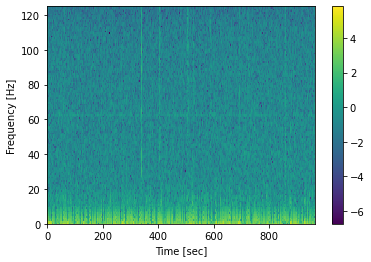

In [135]:
# Plotting STFT Analysis

it = 0 # between 0 to 31
xn = "x"+str(it)
x = np.array(df.iloc[:][xn].T)
f, t, Sxx = signal.stft(x, fs = 250 )
plt.pcolormesh(t, f, np.log(abs(Sxx)))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.show()


In [136]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing

In [46]:
# A Variational AutoEncoder is Modeled for Get Denoised EEG Signal

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    
latent_dim = 8

encoder_inputs = keras.Input(shape=(28, 32, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 8 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 8, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="relu", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 32
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 28, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 14, 16, 32)   320         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 7, 8, 64)     18496       conv2d_4[0][0]                   
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 3584)         0           conv2d_5[0][0]                   
____________________________________________________________________________________________

In [62]:
#Loading The Data from DataFrame

x = np.array(df[col[0:32]]) # all the signals
y = np.array(df[col[32]]) #lables

# Here Main Dataset is Divied by groups of 28 rows and thus one extra dimention is created
data = []
for i in range(1,int(241501/28)):
    data.append(x[(i-1)*28:i*28])

data = np.array(data) # From List, converted to Numpy Array
data = data.reshape(data.shape[0], 28, 32,1) # The last axis with size 1 is added to match with input shape of VAE Model
data_l = y[0:data.shape[0]*data.shape[1]].reshape(data.shape[0],data.shape[1])
print(data.shape)

# data is min max normalized
mn = np.min(data)
mx = np.max(data)
mean = np.mean(data)
data = (data-mn)/(mx-mn)


# Traing The VAE Model

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))
vae.fit(data, epochs=1000, batch_size=1000)

(8624, 28, 32, 1)
Epoch 1/1000
9/9 [==============================] - 0s 28ms/step - loss: 546.2453 - reconstruction_loss: 546.0118 - kl_loss: 0.2335
Epoch 2/1000
9/9 [==============================] - 0s 27ms/step - loss: 546.2640 - reconstruction_loss: 546.0310 - kl_loss: 0.2330
Epoch 3/1000
9/9 [==============================] - 0s 27ms/step - loss: 546.2064 - reconstruction_loss: 545.9767 - kl_loss: 0.2297
Epoch 4/1000
9/9 [==============================] - 0s 27ms/step - loss: 546.2037 - reconstruction_loss: 545.9762 - kl_loss: 0.2275
Epoch 5/1000
9/9 [==============================] - 0s 27ms/step - loss: 546.1699 - reconstruction_loss: 545.9457 - kl_loss: 0.2242
Epoch 6/1000
9/9 [==============================] - 0s 27ms/step - loss: 546.1563 - reconstruction_loss: 545.9363 - kl_loss: 0.2200
Epoch 7/1000
9/9 [==============================] - 0s 27ms/step - loss: 546.1272 - reconstruction_loss: 545.9108 - kl_loss: 0.2164
Epoch 8/1000
9/9 [==============================] - 0s 27m

9/9 [==============================] - 0s 27ms/step - loss: 545.9162 - reconstruction_loss: 545.8671 - kl_loss: 0.0491
Epoch 63/1000
9/9 [==============================] - 0s 27ms/step - loss: 545.9011 - reconstruction_loss: 545.8535 - kl_loss: 0.0476
Epoch 64/1000
9/9 [==============================] - 0s 28ms/step - loss: 545.9575 - reconstruction_loss: 545.9067 - kl_loss: 0.0508
Epoch 65/1000
9/9 [==============================] - 0s 28ms/step - loss: 545.9013 - reconstruction_loss: 545.8511 - kl_loss: 0.0502
Epoch 66/1000
9/9 [==============================] - 0s 30ms/step - loss: 545.8924 - reconstruction_loss: 545.8429 - kl_loss: 0.0495
Epoch 67/1000
9/9 [==============================] - 0s 27ms/step - loss: 545.9404 - reconstruction_loss: 545.8896 - kl_loss: 0.0508
Epoch 68/1000
9/9 [==============================] - 0s 27ms/step - loss: 545.9321 - reconstruction_loss: 545.8795 - kl_loss: 0.0526
Epoch 69/1000
9/9 [==============================] - 0s 28ms/step - loss: 545.9310 

9/9 [==============================] - 0s 27ms/step - loss: 545.8738 - reconstruction_loss: 545.8168 - kl_loss: 0.0570
Epoch 124/1000
9/9 [==============================] - 0s 27ms/step - loss: 545.8722 - reconstruction_loss: 545.8131 - kl_loss: 0.0592
Epoch 125/1000
9/9 [==============================] - 0s 27ms/step - loss: 545.8692 - reconstruction_loss: 545.8139 - kl_loss: 0.0553
Epoch 126/1000
9/9 [==============================] - 0s 27ms/step - loss: 545.8987 - reconstruction_loss: 545.8421 - kl_loss: 0.0566
Epoch 127/1000
9/9 [==============================] - 0s 27ms/step - loss: 545.8894 - reconstruction_loss: 545.8325 - kl_loss: 0.0569
Epoch 128/1000
9/9 [==============================] - 0s 27ms/step - loss: 545.8456 - reconstruction_loss: 545.7881 - kl_loss: 0.0575
Epoch 129/1000
9/9 [==============================] - 0s 27ms/step - loss: 545.9126 - reconstruction_loss: 545.8560 - kl_loss: 0.0566
Epoch 130/1000
9/9 [==============================] - 0s 27ms/step - loss: 54

9/9 [==============================] - 0s 27ms/step - loss: 545.8915 - reconstruction_loss: 545.8318 - kl_loss: 0.0597
Epoch 185/1000
9/9 [==============================] - 0s 27ms/step - loss: 545.8576 - reconstruction_loss: 545.7969 - kl_loss: 0.0607
Epoch 186/1000
9/9 [==============================] - 0s 27ms/step - loss: 545.8633 - reconstruction_loss: 545.8017 - kl_loss: 0.0616
Epoch 187/1000
9/9 [==============================] - 0s 27ms/step - loss: 545.8217 - reconstruction_loss: 545.7610 - kl_loss: 0.0607
Epoch 188/1000
9/9 [==============================] - 0s 27ms/step - loss: 545.8655 - reconstruction_loss: 545.8048 - kl_loss: 0.0607
Epoch 189/1000
9/9 [==============================] - 0s 27ms/step - loss: 545.8851 - reconstruction_loss: 545.8238 - kl_loss: 0.0613
Epoch 190/1000
9/9 [==============================] - 0s 27ms/step - loss: 545.9038 - reconstruction_loss: 545.8411 - kl_loss: 0.0627
Epoch 191/1000
9/9 [==============================] - 0s 27ms/step - loss: 54

9/9 [==============================] - 0s 29ms/step - loss: 545.8415 - reconstruction_loss: 545.7774 - kl_loss: 0.0641
Epoch 246/1000
9/9 [==============================] - 0s 28ms/step - loss: 545.8512 - reconstruction_loss: 545.7872 - kl_loss: 0.0640
Epoch 247/1000
9/9 [==============================] - 0s 27ms/step - loss: 545.8739 - reconstruction_loss: 545.8102 - kl_loss: 0.0637
Epoch 248/1000
9/9 [==============================] - 0s 27ms/step - loss: 545.8791 - reconstruction_loss: 545.8160 - kl_loss: 0.0631
Epoch 249/1000
9/9 [==============================] - 0s 27ms/step - loss: 545.8510 - reconstruction_loss: 545.7871 - kl_loss: 0.0639
Epoch 250/1000
9/9 [==============================] - 0s 27ms/step - loss: 545.8431 - reconstruction_loss: 545.7808 - kl_loss: 0.0623
Epoch 251/1000
9/9 [==============================] - 0s 27ms/step - loss: 545.9036 - reconstruction_loss: 545.8399 - kl_loss: 0.0637
Epoch 252/1000
9/9 [==============================] - 0s 27ms/step - loss: 54

9/9 [==============================] - 0s 27ms/step - loss: 545.8151 - reconstruction_loss: 545.7518 - kl_loss: 0.0632
Epoch 307/1000
9/9 [==============================] - 0s 27ms/step - loss: 545.9084 - reconstruction_loss: 545.8450 - kl_loss: 0.0635
Epoch 308/1000
9/9 [==============================] - 0s 27ms/step - loss: 545.8684 - reconstruction_loss: 545.8055 - kl_loss: 0.0629
Epoch 309/1000
9/9 [==============================] - 0s 27ms/step - loss: 545.8815 - reconstruction_loss: 545.8168 - kl_loss: 0.0648
Epoch 310/1000
9/9 [==============================] - 0s 27ms/step - loss: 545.8922 - reconstruction_loss: 545.8297 - kl_loss: 0.0625
Epoch 311/1000
9/9 [==============================] - 0s 27ms/step - loss: 545.8911 - reconstruction_loss: 545.8287 - kl_loss: 0.0625
Epoch 312/1000
9/9 [==============================] - 0s 27ms/step - loss: 545.8996 - reconstruction_loss: 545.8383 - kl_loss: 0.0613
Epoch 313/1000
9/9 [==============================] - 0s 27ms/step - loss: 54

9/9 [==============================] - 0s 27ms/step - loss: 545.8419 - reconstruction_loss: 545.7775 - kl_loss: 0.0644
Epoch 368/1000
9/9 [==============================] - 0s 27ms/step - loss: 545.8241 - reconstruction_loss: 545.7614 - kl_loss: 0.0627
Epoch 369/1000
9/9 [==============================] - 0s 27ms/step - loss: 545.8453 - reconstruction_loss: 545.7823 - kl_loss: 0.0631
Epoch 370/1000
9/9 [==============================] - 0s 27ms/step - loss: 545.9060 - reconstruction_loss: 545.8432 - kl_loss: 0.0628
Epoch 371/1000
9/9 [==============================] - 0s 27ms/step - loss: 545.8344 - reconstruction_loss: 545.7713 - kl_loss: 0.0631
Epoch 372/1000
9/9 [==============================] - 0s 27ms/step - loss: 545.8176 - reconstruction_loss: 545.7555 - kl_loss: 0.0621
Epoch 373/1000
9/9 [==============================] - 0s 27ms/step - loss: 545.8679 - reconstruction_loss: 545.8058 - kl_loss: 0.0621
Epoch 374/1000
9/9 [==============================] - 0s 27ms/step - loss: 54

KeyboardInterrupt: 

In [63]:
z_mean, z_log_var, z = encoder(np.array(data))
new_data = np.array(decoder(z)) # New Dataset Generated By VAE

In [64]:
# Shape is checked
print(data.shape)
print(new_data.shape)

(8624, 28, 32, 1)
(8624, 28, 32, 1)


In [65]:
print(data_l.shape)

(8624, 28)


In [66]:
# In the main Dataset what we had as the First Coloumn is plotted and Corresponding New Coloumn Generated By VAE is also Plotted to visualize the difference
a = data.reshape(8624*28,32).T[0]
a = a*(mx-mn)+mn
b = new_data.reshape(8624*28,32).T[0]
b = b*(mx-mn)+mn

In [59]:
a.shape

(241472,)

In [60]:
b.shape

(241472,)

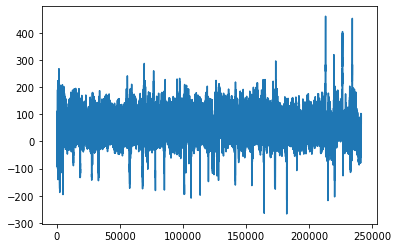

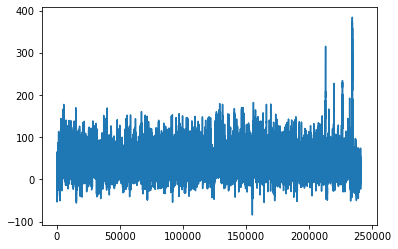

In [67]:
plt.plot(range(a.shape[0]),a)
plt.show()
plt.plot(range(b.shape[0]),b)
plt.show()

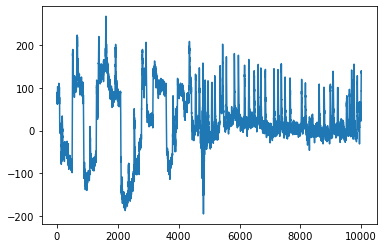

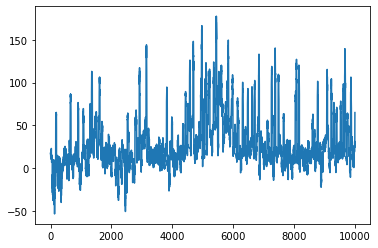

In [76]:
si = 0 # Start Index
ei = 10000 # End Index
plt.plot(range(si,ei),a[si:ei])
plt.show()
plt.plot(range(si,ei),b[si:ei])
plt.show()

In [122]:
# Stacked Encoder Model for Performing Classification
# It will Modeled to deal with 28 rows at a time of The Main dataset
# so At the Output it will return a tensor of size 28 predicting the Probability of beeing Mentally Stressed or not
encoder_inputs = keras.Input(shape=(28, 32, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.MaxPool2D(pool_size=(2, 2), strides=2, padding="same")(x)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 2), strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(74, activation="relu")(x)
x = layers.Dense(28, activation="softmax")(x)
encoder = keras.Model(encoder_inputs, x, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 28, 32, 1)]       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 14, 16, 32)        320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 8, 32)          0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 4, 4, 32)          9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 74)                9546

In [124]:
# The Stacked Encoder MOdel is trained with Binary CrossEntropy Loss And Accuracy matrix is  also printed

encoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss = tf.keras.losses.BinaryCrossentropy(),metrics = ['accuracy'])
encoder.fit(data,data_l, epochs=200, batch_size=5)

Epoch 1/200
1725/1725 [==============================] - 5s 3ms/step - loss: 1.6844 - accuracy: 0.1089
Epoch 2/200
1725/1725 [==============================] - 6s 3ms/step - loss: 1.6844 - accuracy: 0.0982
Epoch 3/200
1725/1725 [==============================] - 5s 3ms/step - loss: 1.6844 - accuracy: 0.2478
Epoch 4/200
1725/1725 [==============================] - 6s 3ms/step - loss: 1.6844 - accuracy: 0.2299
Epoch 5/200
1725/1725 [==============================] - 5s 3ms/step - loss: 1.6844 - accuracy: 0.2403
Epoch 6/200
1725/1725 [==============================] - 5s 3ms/step - loss: 1.6844 - accuracy: 0.1817
Epoch 7/200
1725/1725 [==============================] - 5s 3ms/step - loss: 1.6844 - accuracy: 0.1972
Epoch 8/200
1725/1725 [==============================] - 6s 3ms/step - loss: 1.6844 - accuracy: 0.1698
Epoch 9/200
1725/1725 [==============================] - 6s 3ms/step - loss: 1.6844 - accuracy: 0.1679
Epoch 10/200
1725/1725 [==============================] - 6s 3ms/step - l

1725/1725 [==============================] - 5s 3ms/step - loss: 1.6844 - accuracy: 0.1678
Epoch 80/200
1725/1725 [==============================] - 6s 3ms/step - loss: 1.6844 - accuracy: 0.1874
Epoch 81/200
1725/1725 [==============================] - 5s 3ms/step - loss: 1.6844 - accuracy: 0.1913
Epoch 82/200
1725/1725 [==============================] - 5s 3ms/step - loss: 1.6844 - accuracy: 0.1843
Epoch 83/200
1725/1725 [==============================] - 5s 3ms/step - loss: 1.6844 - accuracy: 0.1744
Epoch 84/200
1725/1725 [==============================] - 6s 4ms/step - loss: 1.6844 - accuracy: 0.2310
Epoch 85/200
1725/1725 [==============================] - 6s 3ms/step - loss: 1.6844 - accuracy: 0.1642
Epoch 86/200
1725/1725 [==============================] - 6s 3ms/step - loss: 1.6844 - accuracy: 0.1948
Epoch 87/200
1725/1725 [==============================] - 5s 3ms/step - loss: 1.6844 - accuracy: 0.1869
Epoch 88/200
1725/1725 [==============================] - 6s 3ms/step - loss:

1725/1725 [==============================] - 6s 4ms/step - loss: 1.6844 - accuracy: 0.2245
Epoch 158/200
1725/1725 [==============================] - 6s 3ms/step - loss: 1.6844 - accuracy: 0.2288
Epoch 159/200
1725/1725 [==============================] - 6s 3ms/step - loss: 1.6844 - accuracy: 0.2113
Epoch 160/200
1725/1725 [==============================] - 6s 3ms/step - loss: 1.6844 - accuracy: 0.2064
Epoch 161/200
1725/1725 [==============================] - 6s 3ms/step - loss: 1.6844 - accuracy: 0.1983
Epoch 162/200
1725/1725 [==============================] - 5s 3ms/step - loss: 1.6844 - accuracy: 0.2281
Epoch 163/200
1725/1725 [==============================] - 6s 3ms/step - loss: 1.6844 - accuracy: 0.1112
Epoch 164/200
1725/1725 [==============================] - 5s 3ms/step - loss: 1.6844 - accuracy: 0.2067
Epoch 165/200
1725/1725 [==============================] - 5s 3ms/step - loss: 1.6844 - accuracy: 0.2435
Epoch 166/200
1725/1725 [==============================] - 5s 3ms/ste

In [ ]:
# So Accuracy Got in 200 epochs is 15 to 25 %.